### Import Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt

### Set up Spark Environment

In [2]:
spark = SparkSession.builder \
    .appName("FlightDelayAnalysis") \
    .config("spark.executor.memory", "5g") \
    .config("spark.executor.cores", "3") \
    .config("spark.executor.instances", "4") \
    .config("spark.driver.memory", "2g") \
    .config("spark.driver.cores", "1") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/13 14:22:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# increase the maximum number of fields that can be displayed when a plan is printed to 100

spark.conf.set("spark.sql.debug.maxToStringFields", "100")

### Loading Dataset

In [4]:
file= """/home/alaa-haggag/Big Data Assesment/Flight Delay/Flight_Delay.parquet"""

In [5]:
flights_whole_df = spark.read.format("parquet").load(file)

In [6]:
flights_whole_df.printSchema()

root
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- FlightDate: string (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- WheelsOff: double (nullable = true)
 |-- WheelsOn: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- CRSArrTime: long (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DistanceGroup: long (nullabl

In [7]:
flights_whole_df.show(5)

+----+-----+----------+----------+-------------------------+--------------+--------------+----------+-------+--------+---------------+-------+---------+--------+------+----------+-------+--------+---------------+--------------+-----------------+-------+--------+-------------+------------+------------+--------+-------------+-----------------+-----------------+
|Year|Month|DayofMonth|FlightDate|Marketing_Airline_Network|OriginCityName|  DestCityName|CRSDepTime|DepTime|DepDelay|DepDelayMinutes|TaxiOut|WheelsOff|WheelsOn|TaxiIn|CRSArrTime|ArrTime|ArrDelay|ArrDelayMinutes|CRSElapsedTime|ActualElapsedTime|AirTime|Distance|DistanceGroup|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|__index_level_0__|
+----+-----+----------+----------+-------------------------+--------------+--------------+----------+-------+--------+---------------+-------+---------+--------+------+----------+-------+--------+---------------+--------------+-----------------+-------+--------+-------------+

### Taking a sample of the data for testing

In [8]:
# Select relevant columns
flights_df = flights_whole_df.select(["FlightDate", "Marketing_Airline_Network", "CarrierDelay", "OriginCityName", "DestCityName", 
                                      "DepDelay", "ArrDelay", "ArrDelayMinutes", "DepTime","Distance"])\
							.sample(False, 0.001, 42)

In [9]:
flights_df.show(5)

+----------+-------------------------+------------+--------------------+---------------+--------+--------+---------------+-------+--------+
|FlightDate|Marketing_Airline_Network|CarrierDelay|      OriginCityName|   DestCityName|DepDelay|ArrDelay|ArrDelayMinutes|DepTime|Distance|
+----------+-------------------------+------------+--------------------+---------------+--------+--------+---------------+-------+--------+
|2018-01-14|                       UA|         0.0| Gulfport/Biloxi, MS|    Houston, TX|   -13.0|   -26.0|            0.0| 1502.0|   376.0|
|2018-01-17|                       DL|         0.0|        Richmond, VA|Minneapolis, MN|    -4.0|    -5.0|            0.0|  846.0|   970.0|
|2018-01-09|                       DL|        26.0|        Richmond, VA|   New York, NY|   172.0|   167.0|          167.0| 1742.0|   292.0|
|2018-01-25|                       DL|         0.0|        Key West, FL|    Atlanta, GA|    -1.0|    -8.0|            0.0|  701.0|   646.0|
|2018-01-19|        

In [10]:
# Check the number of partitions
flights_df.rdd.getNumPartitions()

6

In [11]:
# Repartition the DataFrame into 10 partitions for parallel processing and better memory management

flights_df = flights_df.repartition(10)


### Understanding The data 

In [12]:
flights_df.printSchema()

root
 |-- FlightDate: string (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- CarrierDelay: double (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- Distance: double (nullable = true)



In [14]:
# For better performance, persist the DataFrame in memory
flights_df.persist()

DataFrame[FlightDate: string, Marketing_Airline_Network: string, CarrierDelay: double, OriginCityName: string, DestCityName: string, DepDelay: double, ArrDelay: double, ArrDelayMinutes: double, DepTime: double, Distance: double]

In [15]:
# Count the number of rows in the DataFrame
number_of_rows = flights_df.count()

print("Number of rows in the DataFrame: ", number_of_rows)

Number of rows in the DataFrame:  30417


In [17]:
# show  the nulls in each column

flights_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in flights_df.columns]).show()

+----------+-------------------------+------------+--------------+------------+--------+--------+---------------+-------+--------+
|FlightDate|Marketing_Airline_Network|CarrierDelay|OriginCityName|DestCityName|DepDelay|ArrDelay|ArrDelayMinutes|DepTime|Distance|
+----------+-------------------------+------------+--------------+------------+--------+--------+---------------+-------+--------+
|         0|                        0|           0|             0|           0|       0|       0|              0|      0|       0|
+----------+-------------------------+------------+--------------+------------+--------+--------+---------------+-------+--------+



In [18]:
# show the number of duplicates in the DataFrame

number_of_duplicates =  flights_df.count() - flights_df.dropDuplicates().count()

print("\nNumber of duplicates in the DataFrame: ", number_of_duplicates)


Number of duplicates in the DataFrame:  0


In [19]:
flights_df.describe().show()

+-------+----------+-------------------------+------------------+--------------+------------+------------------+------------------+------------------+------------------+-----------------+
|summary|FlightDate|Marketing_Airline_Network|      CarrierDelay|OriginCityName|DestCityName|          DepDelay|          ArrDelay|   ArrDelayMinutes|           DepTime|         Distance|
+-------+----------+-------------------------+------------------+--------------+------------+------------------+------------------+------------------+------------------+-----------------+
|  count|     30417|                    30417|             30417|         30417|       30417|             30417|             30417|             30417|             30417|            30417|
|   mean|      NULL|                     NULL|  4.69142255975277|          NULL|        NULL| 9.972285235230299|3.1463983956340202| 13.81043495413749| 1324.234441266397|776.5061643160075|
| stddev|      NULL|                     NULL|29.34337163833

### Preprocess the data

In [20]:
# Convert FlightDate to date type
flights_df1 = flights_df.withColumn("FlightDate", flights_df["FlightDate"].cast("date"))

In [21]:
flights_df1.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- CarrierDelay: double (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- Distance: double (nullable = true)



In [22]:
# The total delay for each flight
flights_df2 = flights_df1.withColumn("TotalDelay", flights_df1["DepDelay"] + flights_df1["ArrDelay"])

In [25]:
flights_df2.select('Marketing_Airline_Network','TotalDelay').show(5)

+-------------------------+----------+
|Marketing_Airline_Network|TotalDelay|
+-------------------------+----------+
|                       UA|     -32.0|
|                       DL|     -12.0|
|                       DL|     130.0|
|                       AA|     -26.0|
|                       WN|     -36.0|
+-------------------------+----------+
only showing top 5 rows



In [26]:
# Mapping Marketing_Airline_Network to Carrier Name in a new column

flights_df3 = flights_df2.withColumn('Carrier_Name',when(col('Marketing_Airline_Network')=='AA','American Airlines')\
.when(col('Marketing_Airline_Network')=='AS','Alaska Airlines')\
.when(col('Marketing_Airline_Network')=='B6','JetBlue Airways')\
.when(col('Marketing_Airline_Network')=='DL','Delta Air Lines')\
.when(col('Marketing_Airline_Network')=='F9','Frontier Airlines')\
.when(col('Marketing_Airline_Network')=='G4','Allegiant Air')\
.when(col('Marketing_Airline_Network')=='HA','Hawaiian Airlines')\
.when(col('Marketing_Airline_Network')=='NK','Spirit Airlines')\
.when(col('Marketing_Airline_Network')=='UA','United Airlines')\
.when(col('Marketing_Airline_Network')=='VX','Virgin America')\
.when(col('Marketing_Airline_Network')=='WN','Southwest Airlines')\
.otherwise('Others'))

In [27]:
flights_df3.select("Carrier_Name").distinct().show()

+------------------+
|      Carrier_Name|
+------------------+
|     Allegiant Air|
|   United Airlines|
| Hawaiian Airlines|
| Frontier Airlines|
| American Airlines|
|   Delta Air Lines|
|   JetBlue Airways|
|   Alaska Airlines|
|   Spirit Airlines|
|Southwest Airlines|
|    Virgin America|
+------------------+



In [28]:
# map OriginCityName to Origin_City in a new column and DestCityName to Dest_City in a new column

flights_df4 = flights_df3.withColumn('Origin_City',when(col('OriginCityName')=='Atlanta, GA','Atlanta')\
.when(col('OriginCityName')=='Boston, MA','Boston')\
.when(col('OriginCityName')=='Charlotte, NC','Charlotte')\
.when(col('OriginCityName')=='Chicago, IL','Chicago')\
.when(col('OriginCityName')=='Dallas/Fort Worth, TX','Dallas')\
.when(col('OriginCityName')=='Denver, CO','Denver')\
.when(col('OriginCityName')=='Detroit, MI','Detroit')\
.when(col('OriginCityName')=='Houston, TX','Houston')\
.when(col('OriginCityName')=='Las Vegas, NV','Las Vegas')\
.when(col('OriginCityName')=='Los Angeles, CA','Los Angeles')\
.when(col('OriginCityName')=='Miami, FL','Miami')\
.when(col('OriginCityName')=='Minneapolis, MN','Minneapolis')\
.when(col('OriginCityName')=='New York, NY','New York')\
.when(col('OriginCityName')=='Orlando, FL','Orlando')\
.when(col('OriginCityName')=='Philadelphia, PA','Philadelphia')\
.when(col('OriginCityName')=='Phoenix, AZ','Phoenix')\
.when(col('OriginCityName')=='San Francisco, CA','San Francisco')\
.when(col('OriginCityName')=='Seattle, WA','Seattle')\
.when(col('OriginCityName')=='Washington, DC','Washington')\
.otherwise('Others'))

In [29]:
flights_df4.select("Origin_City").distinct().show()

+-------------+
|  Origin_City|
+-------------+
|      Phoenix|
|       Dallas|
| Philadelphia|
|  Los Angeles|
|San Francisco|
|      Detroit|
|   Washington|
|      Chicago|
|      Atlanta|
|    Las Vegas|
|      Seattle|
|       Others|
|  Minneapolis|
|      Houston|
|        Miami|
|      Orlando|
|     New York|
|    Charlotte|
|       Denver|
|       Boston|
+-------------+



In [30]:
flights_final_df = flights_df4.withColumn('Dest_City',when(col('DestCityName')=='Atlanta, GA','Atlanta')\
.when(col('DestCityName')=='Boston, MA','Boston')\
.when(col('DestCityName')=='Charlotte, NC','Charlotte')\
.when(col('DestCityName')=='Chicago, IL','Chicago')\
.when(col('DestCityName')=='Dallas/Fort Worth, TX','Dallas')\
.when(col('DestCityName')=='Denver, CO','Denver')\
.when(col('DestCityName')=='Detroit, MI','Detroit')\
.when(col('DestCityName')=='Houston, TX','Houston')\
.when(col('DestCityName')=='Las Vegas, NV','Las Vegas')\
.when(col('DestCityName')=='Los Angeles, CA','Los Angeles')\
.when(col('DestCityName')=='Miami, FL','Miami')\
.when(col('DestCityName')=='Minneapolis, MN','Minneapolis')\
.when(col('DestCityName')=='New York, NY','New York')\
.when(col('DestCityName')=='Orlando, FL','Orlando')\
.when(col('DestCityName')=='Philadelphia, PA','Philadelphia')\
.when(col('DestCityName')=='Phoenix, AZ','Phoenix')\
.when(col('DestCityName')=='San Francisco, CA','San Francisco')\
.when(col('DestCityName')=='Seattle, WA','Seattle')\
.when(col('DestCityName')=='Washington, DC','Washington')\
.otherwise('Others'))


In [31]:
flights_final_df.select("Dest_City").distinct().show()

+-------------+
|    Dest_City|
+-------------+
|      Phoenix|
|       Dallas|
| Philadelphia|
|  Los Angeles|
|San Francisco|
|      Detroit|
|   Washington|
|      Chicago|
|      Atlanta|
|    Las Vegas|
|      Seattle|
|       Others|
|  Minneapolis|
|      Houston|
|        Miami|
|      Orlando|
|     New York|
|    Charlotte|
|       Denver|
|       Boston|
+-------------+



In [32]:
flights_final_df.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- CarrierDelay: double (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- TotalDelay: double (nullable = true)
 |-- Carrier_Name: string (nullable = false)
 |-- Origin_City: string (nullable = false)
 |-- Dest_City: string (nullable = false)



In [33]:
# Cache the final processed DataFrame in memory for faster access
flights_final_df.cache()

DataFrame[FlightDate: date, Marketing_Airline_Network: string, CarrierDelay: double, OriginCityName: string, DestCityName: string, DepDelay: double, ArrDelay: double, ArrDelayMinutes: double, DepTime: double, Distance: double, TotalDelay: double, Carrier_Name: string, Origin_City: string, Dest_City: string]

### Analyze the dataset

In [34]:
# What is the average delay time for each airline? 

flights_final_df.groupBy("Carrier_Name").agg(avg("TotalDelay")).show()


+------------------+-------------------+
|      Carrier_Name|    avg(TotalDelay)|
+------------------+-------------------+
|     Allegiant Air| 22.144827586206898|
|   United Airlines| 17.662726008344922|
| Hawaiian Airlines|-0.8032258064516129|
| Frontier Airlines| 23.686851211072664|
| American Airlines| 13.076003086419753|
|   Delta Air Lines|  8.743724635502781|
|   JetBlue Airways|  31.61482820976492|
|   Alaska Airlines| 1.2229567307692308|
|   Spirit Airlines| 17.734430082256168|
|Southwest Airlines|  11.77767265846736|
|    Virgin America| 24.428571428571427|
+------------------+-------------------+



In [37]:
# what the top 10 airlines with the most delay time?

flights_final_df.groupBy("Carrier_Name").agg(sum("TotalDelay").alias("Total_Delay_Time")).orderBy(desc("Total_Delay_Time")).show(10)


+------------------+----------------+
|      Carrier_Name|Total_Delay_Time|
+------------------+----------------+
| American Airlines|        101679.0|
|   United Airlines|        101596.0|
|Southwest Airlines|         62245.0|
|   Delta Air Lines|         58172.0|
|   JetBlue Airways|         34966.0|
|   Spirit Airlines|         15092.0|
| Frontier Airlines|         13691.0|
|     Allegiant Air|          9633.0|
|   Alaska Airlines|          2035.0|
|    Virgin America|           171.0|
+------------------+----------------+
only showing top 10 rows



In [40]:
# What is the most common cause of delays?

flights_final_df.groupBy("CarrierDelay").count().orderBy(desc("count")).show()

+------------+-----+
|CarrierDelay|count|
+------------+-----+
|         0.0|27000|
|         3.0|  126|
|         1.0|  120|
|         6.0|  105|
|         7.0|  101|
|         5.0|  101|
|         4.0|   95|
|        15.0|   95|
|        16.0|   95|
|         2.0|   89|
|        10.0|   88|
|        17.0|   81|
|        18.0|   78|
|         9.0|   76|
|         8.0|   74|
|        11.0|   72|
|        19.0|   72|
|        14.0|   67|
|        12.0|   66|
|        20.0|   65|
+------------+-----+
only showing top 20 rows



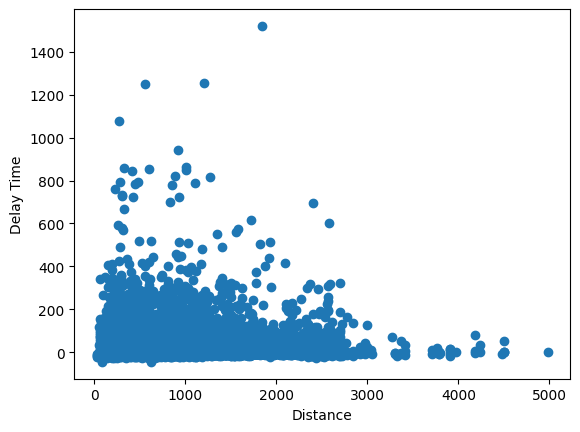

In [41]:
# What is the relationship between distance and delay time?

plt.scatter(flights_final_df.select("Distance").collect(), flights_final_df.select("DepDelay").collect())
plt.xlabel("Distance")
plt.ylabel("Delay Time")
plt.show()


In [42]:
# What is the busiest airport in terms of flight volume?
flights_final_df.groupBy("OriginCityName").count().orderBy(desc("count")).show()

+--------------------+-----+
|      OriginCityName|count|
+--------------------+-----+
|         Chicago, IL| 1679|
|         Atlanta, GA| 1504|
|Dallas/Fort Worth...| 1202|
|          Denver, CO| 1197|
|        New York, NY| 1086|
|       Charlotte, NC|  964|
|         Houston, TX|  925|
|     Los Angeles, CA|  914|
|      Washington, DC|  906|
|         Seattle, WA|  758|
|         Phoenix, AZ|  734|
|         Detroit, MI|  635|
|       Las Vegas, NV|  621|
|         Orlando, FL|  609|
|   San Francisco, CA|  595|
|     Minneapolis, MN|  595|
|          Newark, NJ|  583|
|    Philadelphia, PA|  562|
|          Boston, MA|  543|
|  Salt Lake City, UT|  489|
+--------------------+-----+
only showing top 20 rows



In [43]:
# what is the average delay time by day of week?
flights_final_df.groupBy(dayofweek("FlightDate").alias("DayOfWeek")).agg({"ArrDelayMinutes": "avg"}).orderBy("DayOfWeek").show()

+---------+--------------------+
|DayOfWeek|avg(ArrDelayMinutes)|
+---------+--------------------+
|        1|  14.470213733515234|
|        2|  14.710874755806381|
|        3|  11.588357109986195|
|        4|  12.323670394887012|
|        5|  15.580208564455292|
|        6|  15.030854248215519|
|        7|  12.726727509778357|
+---------+--------------------+



In [45]:
# what is the average delay time by month?

flights_final_df.groupBy(month("FlightDate").alias("Month")).agg(avg("TotalDelay").alias("Average_Delay_Time")).orderBy(desc("Average_Delay_Time")).show(12)

+-----+------------------+
|Month|Average_Delay_Time|
+-----+------------------+
|    7| 25.02173913043478|
|    6| 23.25668934240363|
|    8| 20.52224919093851|
|   12|19.050978792822185|
|    5| 13.80743394536498|
|    2|13.756756756756756|
|    4|11.982881597717546|
|   10| 9.911111111111111|
|    3| 7.760740251156642|
|    1|7.5597938144329895|
|   11|5.8222126560482135|
|    9|1.7886075949367088|
+-----+------------------+



In [46]:
spark.stop()